**用于估计幅度调制噪声包络的 DEMON 谱的 Python 实现。提供两个版本：平方律 DEMON 与希尔伯特变换 DEMON。根据具体应用场景，任一算法都可能更合适。两者都期望输入原始数据的数组以及滤波参数，并返回一个包含对输入数据包络估计值的输出数组。**


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as sg
from math import gcd

In [26]:
def demon_classic_square(waveform, sample_rate, band_hz, lp_env_hz, env_sr, iir_order):
    """
    DEMON（平方律整流）：带通 → 平方 → 包络低通 → 降采样 → Welch 得 DEMON 频谱。
    """
    # ---- 1) 选带（SOS + filtfilt，fs 显式传入） ----
    lo, hi = max(1.0, band_hz[0]), min(band_hz[1], 0.49 * sample_rate)
    if not lo < hi:
        raise ValueError(f"band_hz={band_hz} 与 sample_rate={sample_rate} 冲突")
    sos_bp = sg.butter(iir_order, [lo, hi], btype="bandpass",
                       fs=sample_rate, output="sos")
    x_bp = sg.sosfiltfilt(sos_bp, waveform)

    # ---- 2) 平方律检波 + 去直流 ----
    env = x_bp * x_bp
    env -= env.mean()

    # ---- 3) 包络低通（截止自动钳到将降采样后的 Nyquist 之内）----
    lp_cut = float(min(lp_env_hz, 0.45 * env_sr, 0.49 * sample_rate))
    sos_lp = sg.butter(iir_order, lp_cut, btype="low",
                       fs=sample_rate, output="sos")
    env = sg.sosfiltfilt(sos_lp, env)

    # ---- 4) 抗混叠重采样到 env_sr ----
    if env_sr < sample_rate:
        g = gcd(int(env_sr), int(sample_rate))
        up, down = int(env_sr // g), int(sample_rate // g)
        env = sg.resample_poly(env, up, down)
        env_sr_out = int(env_sr)
    else:
        env_sr_out = int(sample_rate)

    # 再次去直流（数值保险）
    env -= env.mean()

    # ---- 5) Welch 功率谱（更稳，建议优先于单次 FFT）----
    nperseg = min(2048, len(env)) if len(env) >= 512 else max(256, len(env)//2)
    nperseg = max(128, nperseg)
    freqs, Pxx = sg.welch(env, fs=env_sr_out, window='hann',
                          nperseg=nperseg, noverlap=int(nperseg * 0.75),
                          detrend='constant', scaling='density')
    # 线性功率谱（避免 0）
    Pxx = np.maximum(Pxx, 1e-18)

    return {
        "env": env,
        "env_sr": np.array([env_sr_out], dtype=np.int64),
        "freqs": freqs,
        "spectrum": Pxx,
    }

In [27]:
def demon_classic_hilbert(waveform, sample_rate, band_hz, lp_env_hz, env_sr, iir_order):
    """
    DEMON（Hilbert 包络）：带通(SOS+filtfilt) → Hilbert 解析包络 → 去直流
    → 包络低通(SOS+filtfilt) → 抗混叠重采样(resample_poly) → Welch 功率谱密度。
    返回与平方律版本一致的键：'env', 'env_sr', 'freqs', 'spectrum'(线性功率谱)。
    """
    # ---- 1) 选带（显式 fs，SOS + 零相位）----
    lo = max(1.0, float(band_hz[0]))
    hi = min(float(band_hz[1]), 0.49 * sample_rate)
    if not lo < hi:
        raise ValueError(f"band_hz={band_hz} 与 sample_rate={sample_rate} 冲突")

    sos_bp = sg.butter(iir_order, [lo, hi], btype="bandpass",
                       fs=sample_rate, output="sos")
    x_bp = sg.sosfiltfilt(sos_bp, waveform)

    # ---- 2) Hilbert 解析包络 + 去直流 ----
    env = np.abs(sg.hilbert(x_bp))
    env -= env.mean()
    env = env * env   

    # ---- 3) 包络低通（截止钳到未来降采样奈奎 + 原始奈奎之内）----
    lp_cut = float(min(lp_env_hz, 0.45 * env_sr, 0.49 * sample_rate))
    sos_lp = sg.butter(iir_order, lp_cut, btype="low",
                       fs=sample_rate, output="sos")
    env = sg.sosfiltfilt(sos_lp, env)

    # ---- 4) 抗混叠重采样到 env_sr ----
    if env_sr < sample_rate:
        g = gcd(int(env_sr), int(sample_rate))
        up, down = int(env_sr // g), int(sample_rate // g)
        env = sg.resample_poly(env, up, down)
        env_sr_out = int(env_sr)
    else:
        env_sr_out = int(sample_rate)

    # 再次去直流（数值保险）
    env -= env.mean()

    # ---- 5) Welch 功率谱密度（与平方律保持一致）----
    nperseg = min(2048, len(env)) if len(env) >= 512 else max(256, len(env)//2)
    nperseg = max(128, nperseg)
    freqs, Pxx = sg.welch(env, fs=env_sr_out, window='hann',
                          nperseg=nperseg, noverlap=int(nperseg * 0.75),
                          detrend='constant', scaling='density')
    Pxx = np.maximum(Pxx, 1e-18)

    return {
        "env": env,
        "env_sr": np.array([env_sr_out], dtype=np.int64),
        "freqs": freqs,
        "spectrum": Pxx,
    }

In [28]:
def plot_demon_spectrum(spectrum, freqs, xlim_hz, title, save_path=None, drop_dc_hz=1.0, norm_to_peak=True):
    """
    1D DEMON 频谱曲线
    - spectrum: 线性功率谱 或 已为 dB 的谱
    - freqs   : 频率轴（与 spectrum 对齐）
    - in_db   : True 表示 spectrum 已为 dB（如 'spectrum_db'）；False 表示线性功率谱
    - drop_dc_hz: 丢弃直流及极低频（默认 <1 Hz）
    - norm_to_peak: 是否把可视频段峰值归一到 0 dB
    """
    import numpy as np
    import matplotlib.pyplot as plt

    spec = np.asarray(spectrum)
    fr = np.asarray(freqs)

    m = (fr >= drop_dc_hz) & (fr <= xlim_hz)
    
    if not np.any(m):
        raise ValueError("频段掩码为空，请检查 xlim_hz / drop_dc_hz 与 freqs 的范围。")

    if np.iscomplexobj(spec):
        spec = np.abs(spec)
    y_db = 10.0 * np.log10(np.maximum(1e-18, spec[m]))

    # 峰值归一化到 0 dB（更容易观察）
    if norm_to_peak:
        y_db = y_db - np.max(y_db)

    plt.figure(figsize=(12, 8))
    plt.plot(fr[m], y_db, lw=1.2)
    plt.xlim(0, xlim_hz)
    ymin = min(-60, float(y_db.min()))
    plt.ylim(ymin, 2)
    plt.xlabel("DEMON frequency (Hz)")
    plt.ylabel("PSD (dB)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

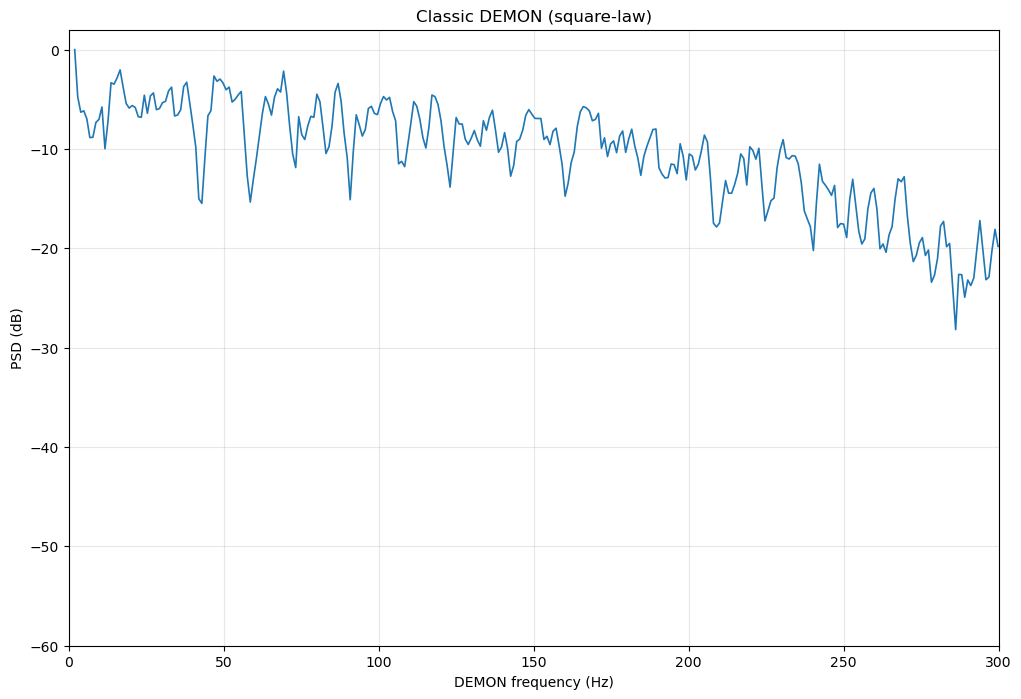

In [29]:
audio_file = r"E:\数据集\ShipEar\data_preprocessing\7_Frame_Windows_8s_50%\6__10_07_13_marDeCangas_Entra_18.wav"
waveform, sample_rate = librosa.load(audio_file, sr=None)
demon_square_features = demon_classic_square(waveform, sample_rate, band_hz=(200,800), lp_env_hz=300, env_sr=2000, iir_order=4)
plot_demon_spectrum(demon_square_features["spectrum"], demon_square_features["freqs"], xlim_hz=300, title="Classic DEMON (square-law)")

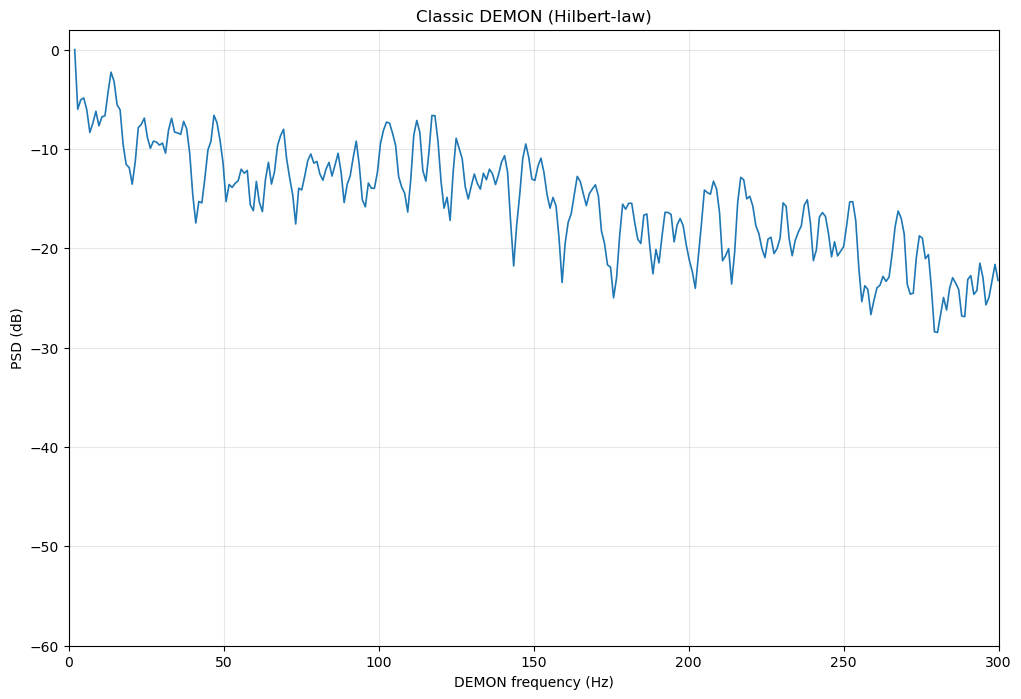

In [31]:
demon_hilbert_features = demon_classic_hilbert(waveform, sample_rate, band_hz=(200.0, 8000.0), lp_env_hz=300, env_sr=2000, iir_order=4)
plot_demon_spectrum(demon_hilbert_features["spectrum"], demon_hilbert_features["freqs"], xlim_hz=300, title="Classic DEMON (Hilbert-law)")